In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import folium
import time
from IPython.display import HTML, display
from category_encoders import CountEncoder
from sklearn.preprocessing import StandardScaler, RobustScaler

In [2]:
data = pd.read_csv('AB_NYC_2019.csv')
data.drop(columns=['id', 'name', 'host_id', 'host_name', 'last_review'], axis=1, inplace=True)
print(data['neighbourhood_group'].unique())
print(data['room_type'].unique())

['Brooklyn' 'Manhattan' 'Queens' 'Staten Island' 'Bronx']
['Private room' 'Entire home/apt' 'Shared room']


In [3]:
data.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,1,365
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0


<AxesSubplot:>

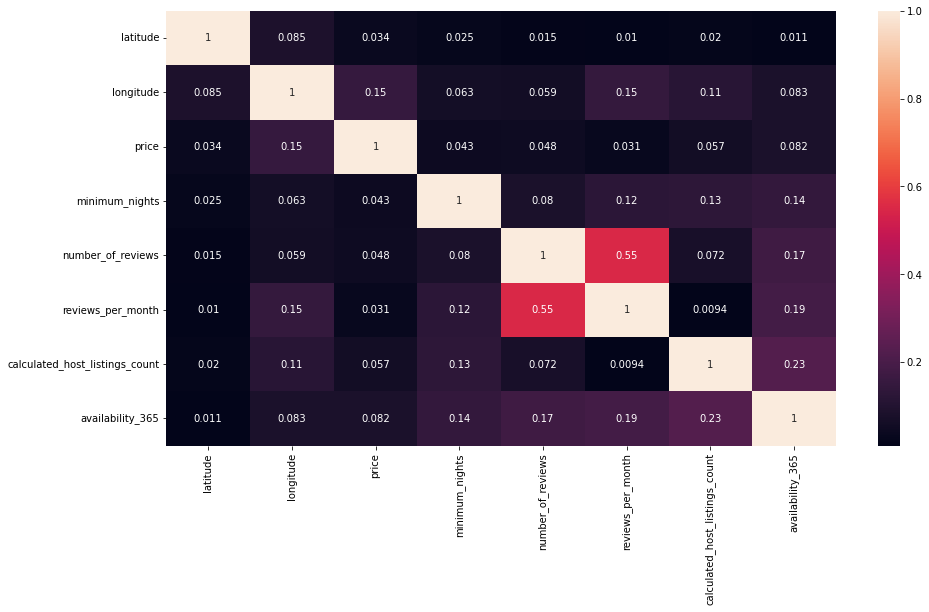

In [4]:
plt.figure(figsize=(15,8))
sns.heatmap(abs(data.corr()), annot=True)

### Если у этого есть координаты, почему бы это не посмотреть на карте. Посмотрим распределение цен по квантилям.

In [5]:
# price_bins=data.price.quantile([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
# data['PriceGroups'] = pd.cut(data['price'], price_bins, \
#                              labels=['0-0.1', '0.1-0.2', '0.2-0.3','0.3-0.4','0.4-0.5',\
#                                      '0.5-0.6', '0.6-0.7', '0.7-0.8', '0.8-0.9', '0.9-1'], 
#                              right=True, include_lowest=True) 

# fig, ax = plt.subplots(figsize=(10,20))


# shape_df = gpd.read_file('nyad.shp').to_crs('EPSG:4326')
# shape_df.plot(ax=ax, color='lightgrey', zorder=1, edgecolor='black', linewidth=1)
# sns.kdeplot(x=data["longitude"], y=data["latitude"], hue=data['PriceGroups'], palette='rocket_r', alpha=0.2, fill=True)

# # условная точка Манхетенна
# sns.scatterplot(x=[-73.993], y=[40.750]) 

# # условная точка Бруклина
# sns.scatterplot(x=[-73.957], y=[40.711])
# data = data.drop(['PriceGroups'], axis=1)

### Самое что ни на есть Манхэттенское расстояние (в градусах, без учёта преград, дорог и т.д.)

 #### Добавим признаки удалённости жилья от данных точек

In [6]:
data['dist_to_manh'] = (abs(data['longitude'] + 73.993) + abs(data['latitude'] - 40.750)) 
data['dist_to_brook'] = (abs(data['longitude'] + 73.957) + abs(data['latitude'] - 40.711))
data = data.drop(['longitude', 'latitude'], axis=1)

### А что если мы возьмём не одну точку, а сетку из точек и выберем наилучшую, скоррелированную с целевой переменной

### Можем наблюдать множество аномальных цен

D:\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


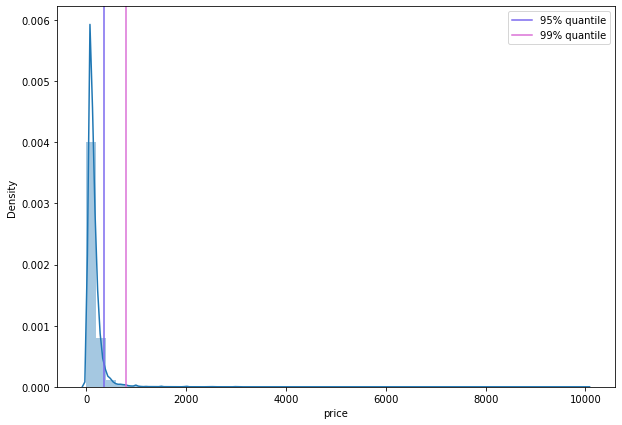

In [7]:
plt.subplots(figsize=(10,7))
sns.distplot(data['price'])
plt.axvline(data.price.quantile(0.95), label='95% quantile', c='mediumslateblue')
plt.axvline(data.price.quantile(0.99), label='99% quantile', c='orchid')
plt.legend()
plt.show()

### Обрежем данные по 90%-ому квантилю целевой переменной

D:\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='price', ylabel='Density'>

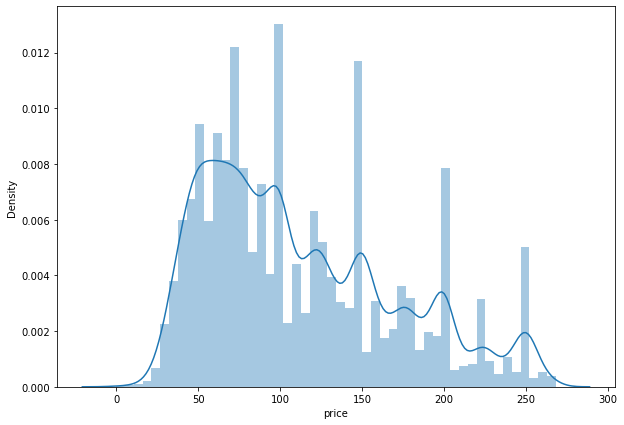

In [8]:
data=data.loc[data.price<data.price.quantile(0.90)]
plt.subplots(figsize=(10,7))
sns.distplot(data['price'])

<AxesSubplot:xlabel='neighbourhood_group', ylabel='price'>

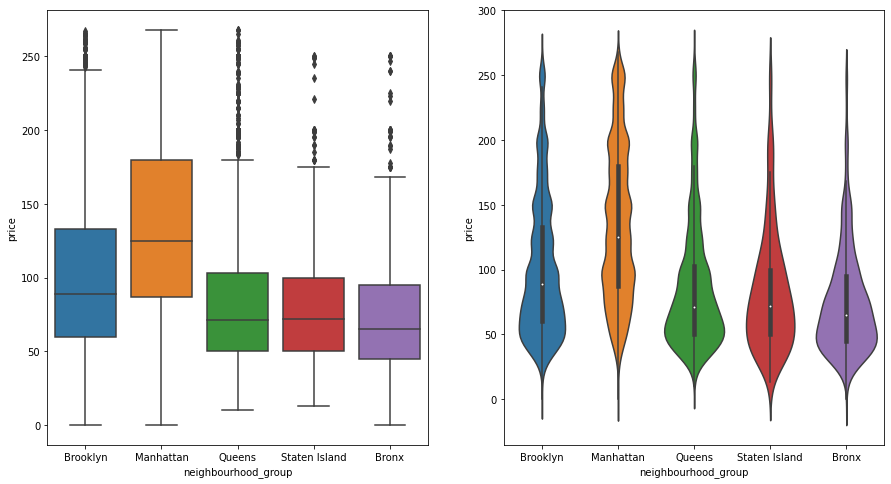

In [9]:
fig, ax = plt.subplots(1,2, figsize=(15, 8))
sns.boxplot(ax=ax[0], data=data, x='neighbourhood_group', y='price')
sns.violinplot(ax=ax[1], data=data, x='neighbourhood_group', y='price')

### Логарифмируем целевую переменную

In [10]:
data['price'] = np.log1p(data.price)

### Nan в reviews_per_month заполним нулями

In [11]:
data['reviews_per_month'] = data['reviews_per_month'].fillna(0)

### Перекодируем районы по принципу Ordinary Encode по мере увеличения средней стоимости жилья

In [12]:
data.groupby('neighbourhood_group').mean()['price'].sort_values()

neighbourhood_group
Bronx            4.198906
Staten Island    4.296415
Queens           4.332228
Brooklyn         4.488223
Manhattan        4.803266
Name: price, dtype: float64

In [13]:
data.groupby('neighbourhood').mean()['price'].sort_values()

neighbourhood
Van Nest        3.802393
Bull's Head     3.819775
Tremont         3.840318
Hunts Point     3.863146
Concord         3.879344
                  ...   
West Village    5.139963
NoHo            5.186785
Neponsit        5.303305
Breezy Point    5.360561
Willowbrook     5.521461
Name: price, Length: 219, dtype: float64

In [14]:
from category_encoders import OrdinalEncoder, OneHotEncoder
enc = OneHotEncoder()

#neighbourhood_groups = data.groupby('neighbourhood_group').mean()['price'].sort_values().index.to_list()
neighbourhoods = data.groupby('neighbourhood').mean()['price'].sort_values().index.to_list()

data = data.drop(['neighbourhood_group', 'room_type'], axis = 1).join(enc.fit_transform(data[['neighbourhood_group', 'room_type']], axis = 0))

In [15]:
encoded_neighbourhoods = {val:i+1 for i, val in enumerate(neighbourhoods)}

data = data.replace({'neighbourhood':encoded_neighbourhoods})


<Figure size 720x576 with 0 Axes>

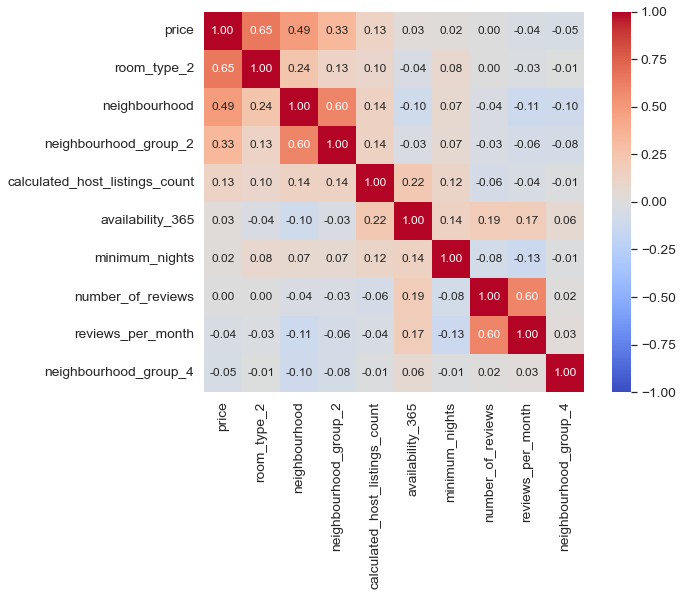

In [16]:
plt.figure(figsize=(10,8))
k = 10 
corrmat = data.corr()
cols = corrmat.nlargest(k, 'price')['price'].index.tolist()
cm = np.corrcoef(data[cols].values.T)
plt.figure(figsize=(10,7))
sns.set(font_scale=1.25)
sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 12},\
                yticklabels=cols, xticklabels=cols, vmin=-1, center=0,\
                    cmap=sns.color_palette('coolwarm',1000))
plt.show()

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.drop(['price'], axis=1), 
                                                    data['price'], test_size=0.30, 
                                                    random_state=42)

In [18]:
from sklearn.linear_model import Ridge, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


ridge_reg = RidgeCV(cv=5)
ridge_reg.fit(X_train, y_train)
у_pred = ridge_reg.predict(X_test)
print(r2_score(y_test, у_pred))

lasso_reg = LassoCV(cv=5, random_state=42)
lasso_reg.fit(X_train, y_train)
print(lasso_reg.score(X_test, y_test))


elastic_reg = ElasticNetCV(cv=5, random_state=42)
elastic_reg.fit(X_train, y_train)
у_pred = elastic_reg.predict(X_test)
print(r2_score(y_test, у_pred))

0.5838420746266794
0.5837500026337007
0.5837433174191431
